# Textile Defect Detection Project

*In the context of textile fabric, rare anomaly can occurs, hence compromizing the quality of the tissus. In order to avoid that in some scenario, it is crucial to detect the defect.*

**Textile Defect Detection** is a *binary classification project* which is able to predict whether the given patch of the fabric is damaged or not *(good)*.

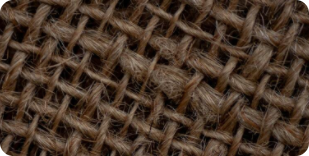

**What will be covered?**


*   Importing the Dataset *(HDF5 format)*.
*   Pre-Exploration (Distribution of Classes)
*   Preprocessig the dataset for binary classification.
*   Exploring the dataset.
*   Setting-up the model callbacks.
*   Setting-up baseline metrics for the evaluation of actual models.
*   Model building, training and evaluation *(Transfer Learning)*.
*   FineTuning the Model.
*   *Model's Deployment?*



## Importing Essential Libraries

In [ ]:
# import the libraries
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object

## Importing Dataset

**Dataset:** The project is based on the [public dataset](https://www.kaggle.com/datasets/belkhirnacim/textiledefectdetection?select=matchingtDATASET_test_32.h5) by the MVTec company. The main goal of this dataset is to explore self-supervised learning on texture images in order to solve anomaly detection problems and learn a robust representation of texture in lieu of traditional image processing features.

The dataset is in **`.h5`** format containing organized by groups of defects, and dataset of patches of **`64x64 pixels`** where patches are sampled at randomized positions, and patches are extract with different angles.

In [ ]:
# install kaggle library
!pip install -q kaggle

# create a hidden kaggle directory
!mkdir ~/.kaggle

# copy the `.json` file containing user's API token 
!cp kaggle.json ~/.kaggle/

# making the `.json` file executable
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download the `textile defect detection` dataset 
!kaggle datasets download -d belkhirnacim/textiledefectdetection

100% 3.40G/3.40G [01:45<00:00, 46.0MB/s]
100% 3.40G/3.40G [01:45<00:00, 34.7MB/s]


In [ ]:
# unzip the dataset
!unzip textiledefectdetection.zip

Archive:  textiledefectdetection.zip
  inflating: matchingtDATASET_test_32.h5  
  inflating: matchingtDATASET_test_64.h5  
  inflating: matchingtDATASET_train_32.h5  
  inflating: matchingtDATASET_train_64.h5  
  inflating: test32.csv              
  inflating: test32.h5               
  inflating: test64.csv              
  inflating: test64.h5               
  inflating: train32.csv             
  inflating: train32.h5              
  inflating: train64.csv             
  inflating: train64.h5              


## Preprocessing the Dataset

### Pre-Exploration of the dataset

Exploration of the dataset is required to get understanding about our classes and to further improve the dataset if required.

It will contain two parts:


*   Exploring the **`train64.csv`** file that contains the information about the dataset that will be used for training the model.
*   Exploring the manipulated dataset to see if the classes are properly labeled.



In [ ]:
# load the `train64.csv` file
train_df64 = pd.read_csv("/content/train64.csv")
train_df64["indication_type"] = train_df64.indication_type.apply(lambda row: "damaged" if row!="good" else "good")
train_df64["indication_value"] = train_df64.indication_value.apply(lambda row: 1 if row!=0 else 0)
train_df64.head()

,index,angle,indication_type,indication_value,split
0,48000,0,good,0,train
1,48001,80,good,0,train
2,48002,100,good,0,train
3,48003,100,good,0,train
4,48004,0,good,0,train


In [ ]:
# check the classes distribution
train_df64.indication_type.value_counts(normalize=True).round(2)

damaged    0.83
good       0.17
Name: indication_type, dtype: float64

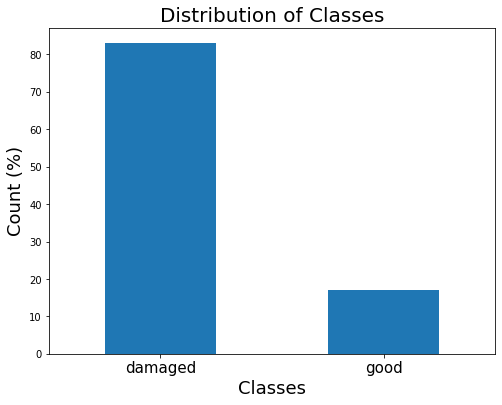

In [ ]:
# plot the distribution of classes
(train_df64.indication_type.value_counts(normalize=True).round(2)*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15);

**⚠ Imbalanced Training Dataset!**

### Preprocessing

The textile defect dataset actually has 6 different classes: `['good', 'color', 'cut', 'hole', 'thread', 'metal_contamination']` along with 8 different rotations `[0, 20, 40, 60, 80, 100, 120, 140]`. Given an image size, a train and test dataset are available with randomly generated patches. Source images from the train and test are non-overlapping.

***But this (overly complicated) dataset is manipulated by `H5ToStorage` object for a binary classification task which contains the following preprocessing steps.***

1.   `64x64 pixels greyscale-image` train and test dataset *(user's choice)* are selected.
2.   The above mentioned *6 classes* are collapsed into only *2 classes* `["damaged", "good"]` with TensorFlow for binary classification. *During this step, the imbalance of the classes is reduced by using data augmentation on `['good']` class training data to produce its three other versions per training sample.*
3.   The image and labels tensors are then loaded and saved back into the storage without burdening the memory, and resulting into a new dataset that is compatible with [tf.data.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). *During this stage, the `"good"` category will produce 4 extra records by data augmentation to eliminate the class imbalance.*
4.   `metadata` is created which contains *file-location as key* and the *rotation as it's value* for exploration purpose.


In [ ]:
# create an object that will take the dataset and produce the dataset in a format required for tensorflow dataset's API
class H5ToStorage:
  def __init__(self, hdf_path, ds_name="train"):
    self.path = hdf_path

    self.classes = []
    with h5py.File(self.path, 'r') as hf:
      for class_ in hf:
        self.classes.append(class_)

    self.name = ds_name

  # a generator to load the (img, class, angle)
  def generate_img_arr(self):
    for class_ in self.classes:
      with h5py.File(self.path, 'r') as hf:
        for angle in hf[class_]:
            for img in hf[class_][f"{angle}"]:
                yield img, class_, angle
  
  # utilize the generator to create new images and load it back to Storage
  def generate_train_dirs(self):
    # create the dataset's directories
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    # random_bright = tf.keras.layers.RandomBrightness(factor=0.05)
    random_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          for j in range(4):
            img_path = f"{path}/{label}/{i}_aug{j}.jpeg"
            img = random_flip(tf.expand_dims(np.squeeze(img), axis=2)*255., training=True)
            plt.imsave(img_path, np.squeeze(img), cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle
    return metadata

  def generate_test_dirs(self):
    # create the dataset's directories
    path = f"./dataset/{self.name}"
    os.makedirs(f"{path}/good/")
    os.makedirs(f"{path}/damaged/")

    gen = self.generate_img_arr()
    metadata = {}

    for i, data in enumerate(gen):
        img, label, angle = data
        if label == "good":
          img_path = f"{path}/{label}/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")
        else:
          img_path = f"{path}/damaged/{i}.jpeg"
          plt.imsave(img_path, np.squeeze(img)*255., cmap="gray")

        metadata[img_path] = angle

    return metadata

  def to_storage(self):
    if self.name == "train":
      self.generate_train_dirs()

    elif self.name == "test":
      self.generate_test_dirs()

In [ ]:
# generate train data
train_gen = H5ToStorage("/content/matchingtDATASET_train_64.h5", "train")
train_dict = train_gen.to_storage()

In [ ]:
# generate test data
test_gen = H5ToStorage("/content/matchingtDATASET_test_64.h5", "test")
test_dict = test_gen.to_storage()

In [ ]:
# train data & test data paths
test_dir = "/content/dataset/test"
train_dir = "/content/dataset/train"

In [ ]:
# create train data pipeline
IMG_SIZE = (64, 64) # define image size
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         color_mode="grayscale",
                                                         label_mode="int", #  label type is encoding of the form `[1, 2, 3, ...]`
                                                         batch_size=64) # batch_size is 32 by default, but 128 will be used for this use-case
# classes in train_data
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()


# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=64,
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache() 

Found 108000 files belonging to 2 classes.
The class_names are as follows: ['damaged', 'good']
Found 36000 files belonging to 2 classes.


## Exploration of the dataset

Exploration of the dataset is required to get understanding about our classes and to further improve the dataset if required.

It will contain two parts:


*   Exploring the generated dataset and check if the class imbalance is reduced as expected.
*   Exploring the manipulated dataset to see if the classes are properly labeled.



In [ ]:
# check the proportions of classes
damaged_counts = 0
for _ in os.listdir(f"{train_dir}/damaged"):
  damaged_counts += 1

good_counts = 0
for _ in os.listdir(f"{train_dir}/good"):
  good_counts += 1

total = damaged_counts + good_counts

new_train_df64 = pd.Series({"damaged": damaged_counts/total,
                            "good": good_counts/total}).round(2)
new_train_df64

damaged    0.56
good       0.44
dtype: float64

**Class Imbalance is significantly reduced!**

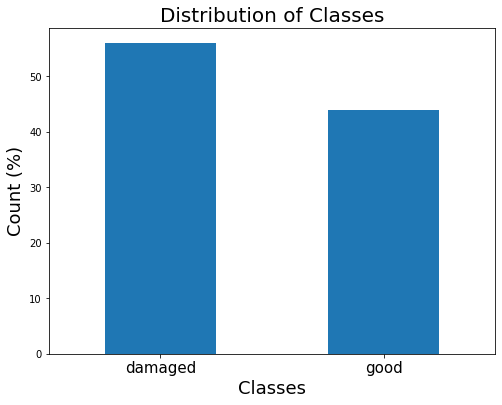

In [ ]:
# check the classes distribution
(new_train_df64*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15);

**Due to the data augmentation during the preprocessing step, the previously Imbalance of Classes has now been reduced significantly!**

**⚠ Warning**

The classes were heavily imbalanced due to the fact that the 5 categories **`['color', 'cut', 'hole', 'thread', 'metal_contamination']`** containing 8000 images each were collapsed into one class **`["damaged"]`** which had 40000 images.

As neural networks were planned to be used for training, this **`1:5`** class imbalance would have made a *20-30%* difference. It is also to be noted that the **`accuracy`** as an evaluation metric is not a robust. **`F1-Score, Precision & Recall`** might provide with more information to evaluate the model's results whether there is class imbalance or not.

*The remaning class imbalance couldn't be reduced as the training data is prone to small changes and will be left as is due to the fact that a more robust model architecture will be used as a feature extractor* 😈.

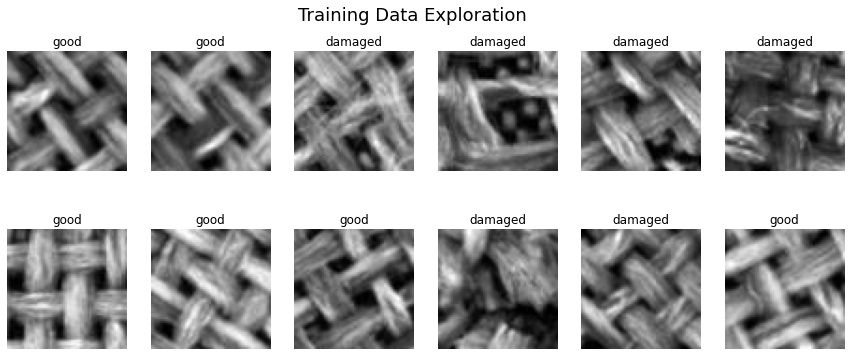

In [ ]:
# explore the train data
def explore_data(n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[label]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
          break;

explore_data(n_rows=2, n_cols=6, figsize=(15, 6))

## Baseline Model

Baseline Model is neccessary to obtain a baseline metric on which the actual model will be evaluated on.

In [ ]:
# create a baseline model to get the baseline metric
baseline_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(64, 64, 1), name="input_layer"),
        tf.keras.layers.Conv2D(3, 1, padding="valid", activation="relu"),
        tf.keras.layers.Conv2D(16, 2, activation="relu"),
        tf.keras.layers.Conv2D(32, 2, activation="relu"),
        tf.keras.layers.Conv2D(64, 3, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(512, 4, activation="relu", kernel_regularizer="l2"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1, activation="sigmoid", name="output_layer")
    ]
)

# get model summary
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 3)         6         
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 16)        208       
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        2080      
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 128)       131200    
                                                        

### Baseline Model's Training

In [ ]:
# define callbacks
# Setup ReduceLROnPlateau callback to reduce learning rate if model's val_loss doesn't improve for 1 epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=1,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3, # if val_accuracy decreases for 3 epochs in a row, stop training
                                                  restore_best_weights=True,
                                                  verbose=1)

In [ ]:
# compile the `baseline_model`
baseline_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

In [ ]:
# train the `baseline_model`
EPOCHS = 20
STEPS_PER_EPOCH = len(train_data)

baseline_training_history = baseline_model.fit(train_data,
                                               epochs=EPOCHS,
                                               steps_per_epoch=STEPS_PER_EPOCH,
                                               validation_data=test_data.shuffle(10000),
                                               validation_steps=int(0.5 * len(test_data)),
                                               callbacks=[reduce_lr, early_stopping]
                                               )

Epoch 1/20
1688/1688 [==============================] - 79s 41ms/step - loss: 0.5955 - accuracy: 0.8427 - val_loss: 0.4121 - val_accuracy: 0.8399 - lr: 0.0010
Epoch 2/20
1688/1688 [==============================] - 61s 36ms/step - loss: 0.3205 - accuracy: 0.8932 - val_loss: 0.3609 - val_accuracy: 0.8553 - lr: 0.0010
Epoch 3/20
1687/1688 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.9019
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1688/1688 [==============================] - 61s 36ms/step - loss: 0.2906 - accuracy: 0.9019 - val_loss: 0.3802 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 4/20
1688/1688 [==============================] - 62s 37ms/step - loss: 0.2436 - accuracy: 0.9195 - val_loss: 0.2896 - val_accuracy: 0.8876 - lr: 2.0000e-04
Epoch 5/20
1688/1688 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9224
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
1688/1688 [==========

### Getting the Baseline Metrics

In [ ]:
# baseline_model's loss and accuracy
baseline_model.evaluate(test_data)

563/563 [==============================] - 9s 16ms/step - loss: 0.2932 - accuracy: 0.8871


[0.293188214302063, 0.8871111273765564]

Well, the baseline_model's accuracy doesn't look bad actually. Getting around 89% accuracy is pretty good though it mostly depend on the data quality and the use-case.

***But is accuracy actually a robust evaluation metric?***

In [ ]:
# create a function to plot evaluation curves
def plot_evaluation_curves(history, restored_weight_epoch=None, annotate_loc=None):

    epochs = range(len(history.history['loss']))
    val_loss, val_accuracy = history.history["val_loss"], history.history["val_accuracy"]
    train_loss, train_accuracy = history.history["loss"], history.history["accuracy"]

    # plot loss curves
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, train_loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend();
    if restored_weight_epoch:
      plt.axvline(restored_weight_epoch-1, color="red", linestyle="--")
    if annotate_loc:  
      plt.annotate("Restored Weights", xy=(restored_weight_epoch-1, 0.05), xytext=annoatate_loc,
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

    # plot accuracy curves
    plt.figure(figsize=(5, 4))
    plt.plot(epochs, train_accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    if restored_weight_epoch:
      plt.axvline(restored_weight_epoch-1, color="red", linestyle="--", label="Restored Accuracy")
    if annotate_loc:
      plt.annotate("Restored Weights", xy=(restored_weight_epoch-1, 0.94), xytext=(0.5, 0.93),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

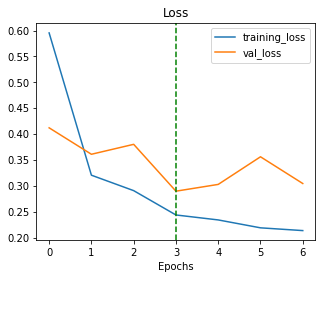

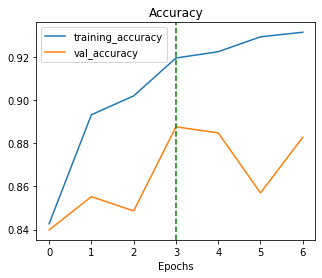

In [ ]:
# plot the accuracy and loss curves
plot_evaluation_curves(baseline_training_history, 4)

The training and validation loss does explain the model's improvement.

**⚠ *But then again, considering the class imbalance in the training dataset, is accuracy really a robust evaluation metric?* Let's find out!**

In [ ]:
# function to get the model's ground truth and predicted labels
def get_labels(dataset, model):
    y_labels = []
    for _, label in tqdm(dataset.unbatch()):
        y_labels.append(label)

    y_preds = model.predict(dataset, verbose=1)
    return y_labels, y_preds

In [ ]:
# get the labels for baseline model
y_labels, y_preds = get_labels(test_data, baseline_model)

36000it [00:05, 7041.27it/s]


563/563 [==============================] - 6s 11ms/step


In [ ]:
# check the labels
y_labels[:2], np.round(y_preds[:2])

([<tf.Tensor: shape=(), dtype=int32, numpy=0>,
  <tf.Tensor: shape=(), dtype=int32, numpy=0>],
 array([[0.],
        [0.]], dtype=float32))

In [ ]:
# get the classification report
print("############### Classification Report ###############\n\n")
print(classification_report(y_labels, np.round(y_preds)))

############### Classification Report ###############


              precision    recall  f1-score   support

           0       0.96      0.91      0.93     30000
           1       0.63      0.79      0.70      6000

    accuracy                           0.89     36000
   macro avg       0.79      0.85      0.82     36000
weighted avg       0.90      0.89      0.89     36000



The precision, recall and f1-score of each classes tell a different story. It is a bit complicated to evaluate the results due to class imbalance in the test dataset. Anyways, the `f1-score` *(which considers both the precision and recall)* of `'good'` class is faring a lot worse than the the `'damaged'` class due to the lack of variety of class's training data quality in the dataset. *Although, the augmented training data had been generated but it wasn't too overly complicated due to the uniqueness of the dataset which also resulted in the lack of the variety of the training data for `['good']` class.*

**But would this trend continue after using a pre-trained state-of-the-art architecture for feature extraction. Let's find out!**

## Transfer Learning

**Transfer learning** is an optimization that allows rapid progress or improved performance when modeling the second task. Transfer learning is the improvement of learning in a new task through the transfer of knowledge from a related task that has already been learned reducing the time to re-train a model from scrath.

### Model Building

The pre-trained model used for this use case was **BiT-m R50x1** trained on the **angiosperm** tree of the **ImageNet21k dataset**. The intuition behind choosing such a model was because the resnet architecture was robust due to residual connections and also the angiosperms which the model was trained on might exhibit the same low level features as that of the fabric's threads.

In [ ]:
# feature extractor trained on angiosperms
module = hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/angiosperm/1",
                        trainable=False,
                        name='feature_extraction_layer',
                        input_shape=IMG_SIZE+(3,))

In [ ]:
# build the sequential model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(3, 1, padding="same", activation="relu"),  # the following feature extraction layer won't accept the data of shape `(None, 64, 64, 1)`
                                                                          # to solve this issue, it is required that the channels are expanded form `1` to `3` by using 1x1 convolution
        module,  # feature extractor layer
        tf.keras.layers.Dense(256, activation="relu", name="dense_layer"),
        tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer')  # making predictions
    ]
)

In [ ]:
# build the model and check summary
model.build((None, 64, 64, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 3)         6         
                                                                 
 feature_extraction_layer (K  (None, 2048)             23500352  
 erasLayer)                                                      
                                                                 
 dense_layer (Dense)         (None, 256)               524544    
                                                                 
 output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 24,025,159
Trainable params: 524,807
Non-trainable params: 23,500,352
_________________________________________________________________


In [ ]:
# check if the training of the feature extractor is set to inference
for i, layer in enumerate(model.layers):
  print(f"{i+1}: The {layer.name}'s training is set to {layer.trainable}")

1: The conv2d's training is set to True
2: The feature_extraction_layer's training is set to False
3: The dense_layer's training is set to True
4: The output_layer's training is set to True


Every layer's training is set except the feature extractor's (which is solely used for inference).

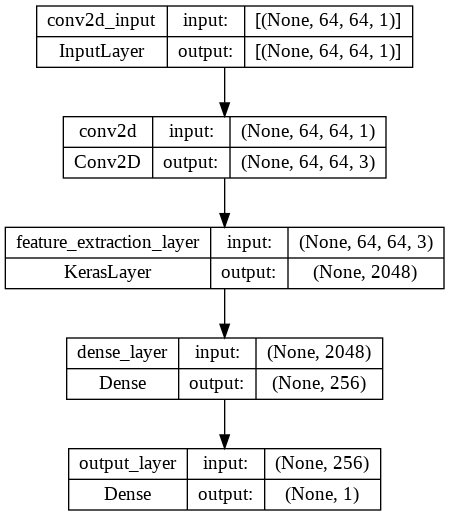

In [ ]:
# plot the model
tf.keras.utils.plot_model(
    model,
    # to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [ ]:
# Define the loss function
binary_categorical_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [ ]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
# Compile the model
model.compile(
      loss=binary_categorical_loss,
      optimizer=optimizer,
      metrics=["accuracy"]
      )

In [ ]:
# train the model
EPOCHS = 10
STEPS_PER_EPOCH = len(train_data)

training_history_1 = model.fit(train_data,
                             epochs=EPOCHS,
                             steps_per_epoch=STEPS_PER_EPOCH,
                             validation_data=test_data.shuffle(10000),
                             validation_steps=int(0.5 * len(test_data)),
                             callbacks=[reduce_lr, early_stopping]
                             )

Epoch 1/10
1688/1688 [==============================] - 215s 117ms/step - loss: 0.2182 - accuracy: 0.9490 - val_loss: 0.2456 - val_accuracy: 0.9161 - lr: 0.0100
Epoch 2/10
1688/1688 [==============================] - 182s 108ms/step - loss: 0.1009 - accuracy: 0.9611 - val_loss: 0.1834 - val_accuracy: 0.9339 - lr: 0.0100
Epoch 3/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9654
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
1688/1688 [==============================] - 183s 109ms/step - loss: 0.0895 - accuracy: 0.9654 - val_loss: 0.3847 - val_accuracy: 0.8886 - lr: 0.0100
Epoch 4/10
1688/1688 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9797
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
Restoring model weights from the end of the best epoch: 2.
1688/1688 [==============================] - 183s 109ms/step - loss: 0.0519 - accuracy: 0.9797 - val_loss: 0.5110 - val_a

### Model's Evaluation

In [ ]:
model.evaluate(test_data)

563/563 [==============================] - 25s 43ms/step - loss: 0.1871 - accuracy: 0.9316


[0.18707706034183502, 0.9315555691719055]

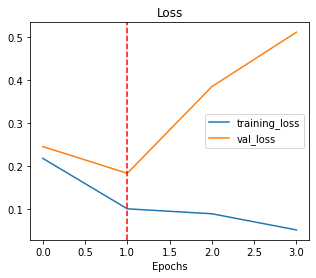

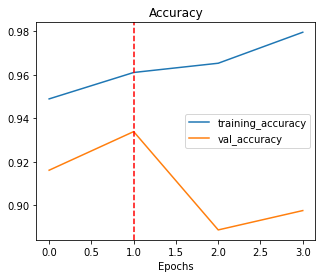

In [ ]:
plot_evaluation_curves(training_history_1, 2)

The accuracy has increased by 5% which is a big improvement which exhibits the tradeoff between accuracy and number of parameters.

**Has the `F1-Score` improved too?**

In [ ]:
# create classification_report
y_labels_1, y_preds_1 = get_labels(test_data, model)

print("\n\n############### Classification Report ###############\n\n")
print(classification_report(y_labels_1, np.round(y_preds_1)))

36000it [00:05, 7043.64it/s]


563/563 [==============================] - 24s 40ms/step


############### Classification Report ###############


              precision    recall  f1-score   support

           0       0.97      0.95      0.96     30000
           1       0.76      0.86      0.81      6000

    accuracy                           0.93     36000
   macro avg       0.87      0.90      0.88     36000
weighted avg       0.94      0.93      0.93     36000



There is a big improvement in the **F1-Score** of the `'good'` class. Precision and Recall have improved and the model has become better but it's still not enough.

**Let's perform fine-tuning which might hopefully improve the model's performance!**

In [ ]:
# model.save("/content/drive/MyDrive/Portfolio/Anomaly Detection/V6/save_model_1")

In [ ]:
# !touch '/content/drive/MyDrive/Portfolio/Anomaly Detection/V6/pickle_1.pickle'
# dbfile = open('/content/drive/MyDrive/Portfolio/Anomaly Detection/V6/pickle_1.pickle', 'ab')
# pickle.dump(training_history_1, dbfile)
# dbfile.close()

## FineTuning the Model

Fine-Tuning a model usually involves an additional step which is to set the pre-trained model for training.

### Setting up Feature Extractor for Training

In [ ]:
# # load the model
# model = tf.keras.models.load_model("/content/drive/MyDrive/Portfolio/Anomaly Detection/V6/save_model_1")

In [ ]:
# set the feature extractor's layer to training
model.layers[1].trainable = True

# check if the training of the feature extractor is set to training
for i, layer in enumerate(model.layers):
  print(f"{i+1}: The {layer.name}'s training is set to {layer.trainable}")

1: The conv2d's training is set to True
2: The feature_extraction_layer's training is set to True
3: The dense_layer's training is set to True
4: The output_layer's training is set to True


In [ ]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
# Compile the model
model.compile(
      loss=binary_categorical_loss,
      optimizer=optimizer,
      metrics=["accuracy"]
      )

In [ ]:
# train the model
EPOCHS = 10
STEPS_PER_EPOCH = len(train_data)

training_history_2 = model.fit(train_data,
                             epochs=EPOCHS,
                             steps_per_epoch=STEPS_PER_EPOCH,
                             validation_data=test_data.shuffle(10000),
                             validation_steps=int(0.5 * len(test_data)),
                             callbacks=[reduce_lr, early_stopping]
                             )

Epoch 1/10
1125/1125 [==============================] - 214s 162ms/step - loss: 0.0570 - accuracy: 0.9850 - val_loss: 0.2293 - val_accuracy: 0.9541 - lr: 1.0000e-04
Epoch 2/10
1125/1125 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9971
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
1125/1125 [==============================] - 176s 156ms/step - loss: 0.0085 - accuracy: 0.9971 - val_loss: 0.4795 - val_accuracy: 0.9332 - lr: 1.0000e-04
Epoch 3/10
1125/1125 [==============================] - ETA: 0s - loss: 1.9380e-05 - accuracy: 1.0000
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
1125/1125 [==============================] - 176s 156ms/step - loss: 1.9380e-05 - accuracy: 1.0000 - val_loss: 0.2626 - val_accuracy: 0.9607 - lr: 2.0000e-05
Epoch 4/10
1125/1125 [==============================] - ETA: 0s - loss: 2.3093e-06 - accuracy: 1.0000
Epoch 4: ReduceLROnPlateau reducing learning rate to 7.9999999798019

### Evaluating the FineTuned Model

In [ ]:
# evaluate the fine-tuned model
model.evaluate(test_data)

563/563 [==============================] - 34s 45ms/step - loss: 0.2647 - accuracy: 0.9613


[0.2646585702896118, 0.9613333344459534]

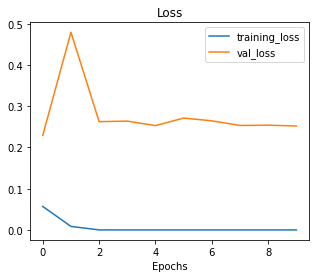

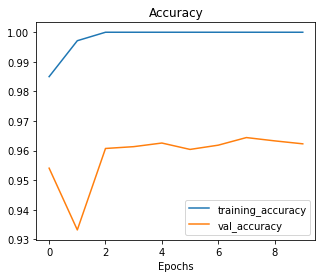

In [ ]:
# plot the accuracy and loss curves
plot_evaluation_curves(training_history_2)

In [ ]:
# create classification_report
y_labels_2, y_preds_2 = get_labels(test_data, model)

print("\n\n############### Classification Report ###############\n\n")
print(classification_report(y_labels_2, y_preds_2))

36000it [00:12, 2966.99it/s]


563/563 [==============================] - 31s 41ms/step


############### Classification Report ###############


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     30000
           1       0.85      0.94      0.89      6000

    accuracy                           0.96     36000
   macro avg       0.92      0.95      0.93     36000
weighted avg       0.96      0.96      0.96     36000



**Model has improved significantly!**

The F1-Score of `'good'` class has jumped to `0.89` and the `macro-average f1-score` is `0.93` which proves that the model is performing better than the baseline model.

In [ ]:
# model.save("/content/drive/MyDrive/Portfolio/Anomaly Detection/V6/save_model_2")

In [ ]:
# model.save("/content/drive/MyDrive/Portfolio/Anomaly Detection/V6/save_model_3")

## Best Model

In [ ]:
# create data frame to show the metrics of the models
baseline_precision, baseline_recall, baseline_f1 = 0.79, 0.85, 0.82
model_precision, model_recall, model_f1 = 0.87, 0.90, 0.88
fineTuned_model_precision, fineTuned_model_recall, fineTuned_model_f1 = 0.92, 0.95, 0.93

metrics_df = pd.DataFrame([[baseline_precision, baseline_recall, baseline_f1],
                           [model_precision, model_recall, model_f1],
                           [fineTuned_model_precision, fineTuned_model_recall, fineTuned_model_f1]],
                          index=['Baseline Model', 'Model (Transfer Learning)', 'Fine Tuned Model'])

metrics_df.columns = ['Precision', 'Recall', 'F1-Score']

metrics_df 

,Precision,Recall,F1-Score
Baseline Model,0.79,0.85,0.82
Model (Transfer Learning),0.87,0.90,0.88
Fine Tuned Model,0.92,0.95,0.93


In [ ]:
fig = px.bar(
    data_frame=metrics_df,
    barmode="group",
    title="Models' Comparison",
    width=650,
    height=500
)

fig.update_layout(xaxis_title="Models", yaxis_title="Metrics", legend_title_text="Metric")

fig.show()

**As seen from the Bar Plot above, Fine Tuned model is performing better than other models and is thus the final chosen model!**

## Model Deployment

This section will be covered seperately!